In [1]:
import torch
from torchvision import models
from PIL import Image
from torchvision import transforms
import os
import numpy as np
from torch import optim
import matplotlib.pyplot as plt

In [2]:
vgg = models.vgg19(pretrained=True)
vgg = vgg.features

In [3]:
for parameters in vgg.parameters():
    parameters.requires_grad_(False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
vgg = vgg.to(device)

In [6]:
def preprocess(img_path, max_size=500):
    image = Image.open(img_path).convert('RGB')
    size = min(max_size, max(image.size))
    
    img_transforms = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])
    
    image = img_transforms(image)
    return image.unsqueeze(0)

In [7]:
content_preprocess = preprocess(os.path.abspath(os.getcwd())+'/Images/content1.jpg')
style_preprocess = preprocess(os.path.abspath(os.getcwd())+'/Images/style7.jpg')

In [8]:
content_preprocess = content_preprocess.to(device)
style_preprocess = style_preprocess.to(device)

In [9]:
def deprocess(tensor):
    image = tensor.to('cpu').clone()
    image = image.numpy()
    image = image.squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = image.clip(0, 1)
    
    return image

In [10]:
content_d = deprocess(content_preprocess)
style_d = deprocess(style_preprocess)

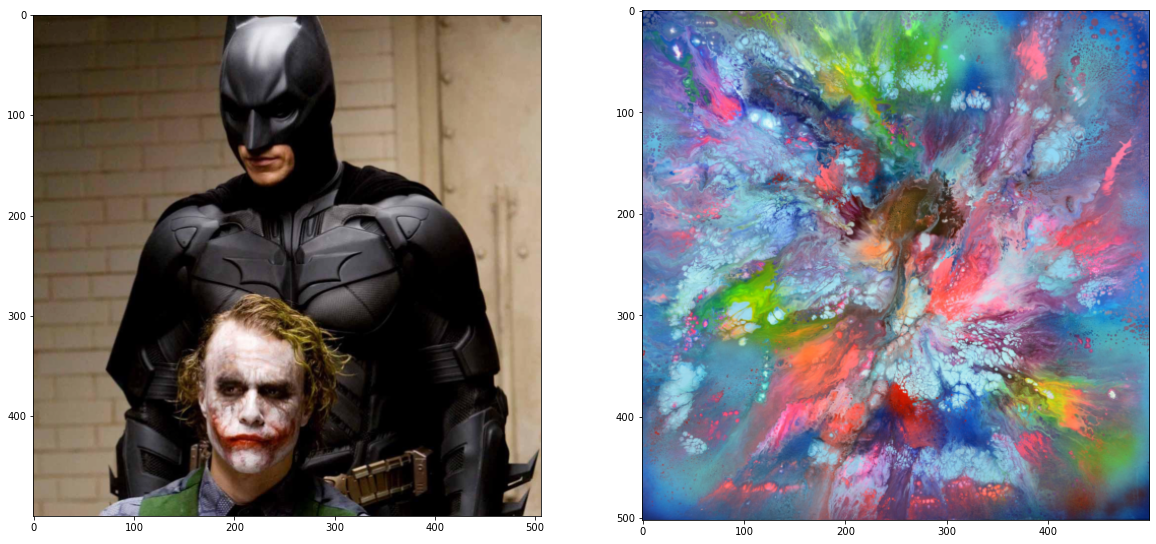

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(content_d)
ax2.imshow(style_d)

In [12]:
def get_features(image, model):
    layers = {
        '0': 'conv1_1',  #style feature
        '5': 'conv2_1',  #style feature
        '10': 'conv3_1', #style feature
        '19': 'conv4_1', #style feature
        '21': 'conv4_2', #content feature
        '28': 'conv5_1'  #style feature
    }
    
    x = image
    
    Features = {}
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            Features[layers[name]] = x
        
    return Features

In [13]:
content_f = get_features(content_preprocess, vgg)
style_f = get_features(style_preprocess, vgg)

In [14]:
def gram_matrix(tensor):
    batch_size, channels, height, width = tensor.size()
    tensor = tensor.view(channels, height*width)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [15]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

In [16]:
def content_loss(target_conv4_2, content_4_2):
    loss = torch.mean((target_conv4_2 - content_4_2)**2)
    return loss

In [17]:
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

In [18]:
def style_loss(style_weights, target_features, style_grams):
    loss = 0
    for layer in style_weights:
        target_f = target_features[layer]
        target_gram = gram_matrix(target_f)
        style_gram = style_grams[layer]
        batch_size, channels, height, weight = target_f.shape
        layer_loss = style_weights[layer] * torch.mean((target_gram-style_gram)**2)
        loss += layer_loss/(channels*height*weight)
        
    return loss

In [19]:
target = content_preprocess.clone().requires_grad_(True).to(device)
target_f = get_features(target, vgg)
print("Content Loss:", content_loss(target_f['conv4_2'], content_f['conv4_2']))
print("Style Loss:", style_loss(style_weights, target_f, style_grams))

Content Loss: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style Loss: tensor(336.6596, device='cuda:0', grad_fn=<AddBackward0>)


In [20]:
optimizer = optim.Adam([target], lr=0.003)

epochs = 3000
show_res = 500

In [21]:
def loss(c_loss, s_loss, alpha=1, beta=1e5):
    loss = alpha*c_loss + beta*s_loss
    return loss

In [ ]:
results = []
for i in range(1, epochs+1):
    target_f = get_features(target, vgg)
    c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
    s_loss = style_loss(style_weights, target_f, style_grams)
    t_loss = loss(c_loss, s_loss)
    
    optimizer.zero_grad()
    t_loss.backward()
    optimizer.step()
    
    if i==1 or i%show_res==0:
        print(f"Epoch: {i}\tLoss:{t_loss}")
        results.append(deprocess(target.detach()))

Epoch: 1	Loss:33665964.0


In [ ]:
plt.figure(figsize=(10, 8))
for i in range(len(results)-1):
    plt.subplot(3, 2, i+1)
    plt.imshow(results[i])
plt.show()

In [ ]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_preprocess)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)